## An example of many-to-one (sequence classification)


Original experiment from Hochreiter & Schmidhuber (1997).

The goal is to classify sequences. Elements and targets are represented locally (input vectors with only one non-zero bit). The sequence starts with an B, ends with a E (the “trigger symbol”), and otherwise consists of randomly chosen symbols from the set {a, b, c, d} except for two elements at positions t1 and t2 that are either X or Y. For the DifficultyLevel.HARD case, the sequence length is randomly chosen between 100 and 110, t1 is randomly chosen between 10 and 20, and t2 is randomly chosen between 50 and 60. There are 4 sequence classes Q, R, S, and U, which depend on the temporal order of X and Y.

The rules are:

* X, X -> Q,
* X, Y -> R,
* Y, X -> S,
* Y, Y -> U.

### Dataset

In [2]:
from res.sequential_tasks import TemporalOrderExp6aSequence as QRSU

In [3]:
example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=32
)

example_batch = example_generator[1]

example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [0. 1. 0. 0.]


In [5]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BXccYaaE
The class label is: R


# Defining the model

In [6]:
import torch
import torch.nn as nn

torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        h = self.rnn(x)[0]
        x = self.linear(h)
        
        return x
    
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c
                

# Defining the Training Loop

In [7]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as droptout.
    model.train()
    
    num_correct = 0
    
    for batch_idx in range(len(train_data_gen)):
        
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)
        
        output = model(data)
        
        # pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]
        
        target = target.argmax(dim=1)
        
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()
        
    return num_correct, loss.item()
        

# Defining the Testing Loop

In [8]:
def test(model, test_data_gen, criterion, device):
    model.eval()
    
    num_correct = 0
    
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)
            
            output = model(data)
            output = output[:, -1, :]
            
            target = target.argmax(dim=1)
            loss = criterion(output, target)
            
            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()
    
    return num_correct, loss.item()

# Putting it All Together

In [9]:
import matplotlib.pyplot as plt
from res.plot_lib import set_default, plot_state, print_colourbar

In [10]:
set_default()

In [11]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}
    
    for epoch in range(max_epochs):
        
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen)*train_data_gen.batch_size)*100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)
        
        
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen)*test_data_gen.batch_size)*100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)
        
        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")
        
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()
                  
    return model

# Simple RNN: 10 epochs

[Epoch 1/100] loss: 1.3775, acc: 25.71% - test_loss: 1.4097, test_acc: 26.71%
[Epoch 2/100] loss: 1.3984, acc: 23.69% - test_loss: 1.3976, test_acc: 25.10%
[Epoch 3/100] loss: 1.3939, acc: 26.71% - test_loss: 1.4495, test_acc: 25.30%
[Epoch 4/100] loss: 1.4258, acc: 25.10% - test_loss: 1.3684, test_acc: 25.91%
[Epoch 5/100] loss: 1.4053, acc: 25.40% - test_loss: 1.4034, test_acc: 27.32%
[Epoch 6/100] loss: 1.3825, acc: 31.96% - test_loss: 1.3839, test_acc: 31.15%
[Epoch 7/100] loss: 1.3630, acc: 32.26% - test_loss: 1.3944, test_acc: 31.96%
[Epoch 8/100] loss: 1.3382, acc: 31.15% - test_loss: 1.4118, test_acc: 28.02%
[Epoch 9/100] loss: 1.3949, acc: 29.74% - test_loss: 1.3710, test_acc: 31.35%
[Epoch 10/100] loss: 1.3762, acc: 31.96% - test_loss: 1.3590, test_acc: 30.54%
[Epoch 11/100] loss: 1.3717, acc: 31.35% - test_loss: 1.3582, test_acc: 37.80%
[Epoch 12/100] loss: 1.3272, acc: 36.09% - test_loss: 1.3592, test_acc: 35.08%
[Epoch 13/100] loss: 1.3585, acc: 36.19% - test_loss: 1.3182,

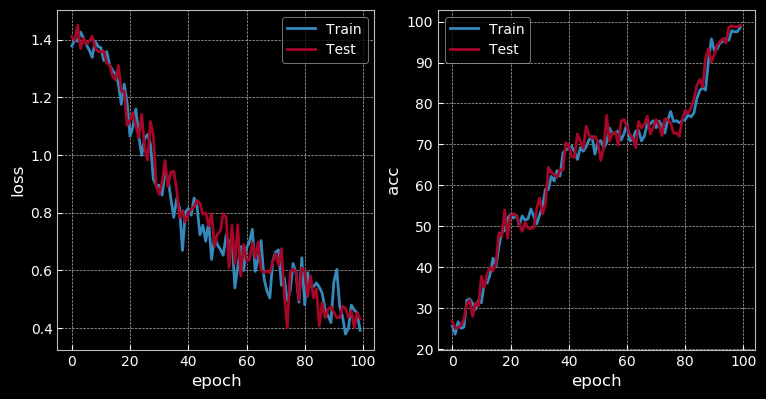

In [17]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [18]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([4, 8])
torch.Size([4, 4])
torch.Size([4])
torch.Size([4])
torch.Size([4, 4])
torch.Size([4])


[Epoch 1/100] loss: 1.4771, acc: 23.79% - test_loss: 1.3389, test_acc: 26.61%
[Epoch 2/100] loss: 1.3308, acc: 24.60% - test_loss: 1.3737, test_acc: 30.95%
[Epoch 3/100] loss: 1.3531, acc: 40.12% - test_loss: 1.3913, test_acc: 48.08%
[Epoch 4/100] loss: 1.3571, acc: 46.47% - test_loss: 1.3325, test_acc: 48.19%
[Epoch 5/100] loss: 1.2803, acc: 51.92% - test_loss: 1.3183, test_acc: 45.36%
[Epoch 6/100] loss: 1.2564, acc: 53.83% - test_loss: 1.2202, test_acc: 61.29%
[Epoch 7/100] loss: 1.1661, acc: 67.34% - test_loss: 1.2037, test_acc: 70.36%
[Epoch 8/100] loss: 1.1197, acc: 85.99% - test_loss: 1.1476, test_acc: 97.48%
[Epoch 9/100] loss: 1.0567, acc: 84.68% - test_loss: 0.9886, test_acc: 79.44%
[Epoch 10/100] loss: 1.0016, acc: 80.24% - test_loss: 0.9229, test_acc: 84.17%
[Epoch 11/100] loss: 0.9059, acc: 87.30% - test_loss: 0.8084, test_acc: 92.54%
[Epoch 12/100] loss: 0.7410, acc: 94.46% - test_loss: 0.7565, test_acc: 93.15%
[Epoch 13/100] loss: 0.7786, acc: 95.97% - test_loss: 0.6880,

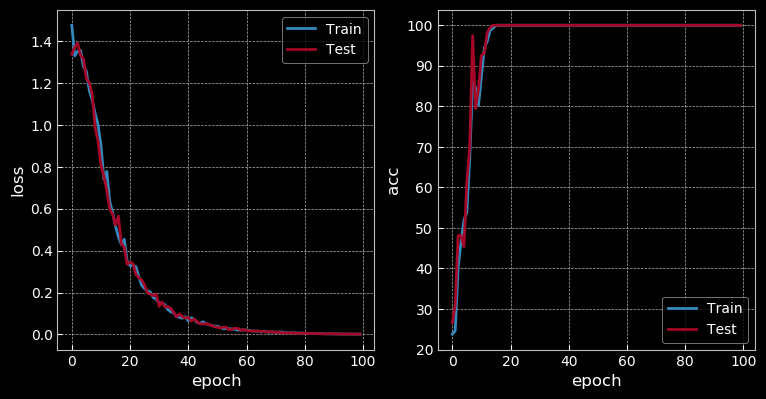

In [19]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)


input_size = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model = SimpleLSTM(input_size, hidden_size, output_size)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs = 100

model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [ ]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

# Model Evaluation

In [23]:
import collections
import random

def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Define a dictionary that maps class indices to labels
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator
    data_generator = QRSU.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears
    count_classes = collections.Counter()
    
    correct = []
    incorrect = []
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)
            
            data_decoded = data_generator.decode_x_batch(data.cpu().numpy())
            target_decoded = data_generator.decode_y_batch(target.cpu().numpy())
            
            output = model(data)
            sequence_end = torch.tensor([len(sequence) for sequence in data_decoded]) - 1
            output = output[torch.arange(data.shape[0]).long(), sequence_end, :]
            
            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]
            
            count_classes.update(target_decoded)
            
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))
    
    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')
    
    # Report the accuracy by class
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')

    # Report some random sequences for examination
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)]
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\nThere were no misclassified sequences.')   

In [24]:
evaluate_model(model, difficulty)

The accuracy of the model is measured to be 88.81%.

Q: 258 / 258 correct
R: 198 / 249 correct
S: 172 / 232 correct
U: 253 / 253 correct

Here are some example sequences:
BYbdYabE -> U was labelled U
BYbdYabE -> U was labelled U
BXacbYdE -> R was labelled R
BbXaXdE -> Q was labelled Q
BcXbYdaE -> R was labelled R
BcYacYbE -> U was labelled U
BcXbYdaE -> R was labelled R
BcYdYdaE -> U was labelled U
BcYdYdaE -> U was labelled U
BYbdYabE -> U was labelled U

There were no misclassified sequences.


# Visualize LSTM

[Epoch 1/20] loss: 1.3896, acc: 23.69% - test_loss: 1.3813, test_acc: 25.30%
[Epoch 2/20] loss: 1.3797, acc: 25.00% - test_loss: 1.3926, test_acc: 24.90%
[Epoch 3/20] loss: 1.3849, acc: 23.39% - test_loss: 1.3861, test_acc: 24.19%
[Epoch 4/20] loss: 1.3821, acc: 24.19% - test_loss: 1.3861, test_acc: 24.40%
[Epoch 5/20] loss: 1.3898, acc: 27.72% - test_loss: 1.3954, test_acc: 25.30%
[Epoch 6/20] loss: 1.4000, acc: 23.89% - test_loss: 1.3914, test_acc: 26.01%
[Epoch 7/20] loss: 1.3791, acc: 26.61% - test_loss: 1.3868, test_acc: 26.01%
[Epoch 8/20] loss: 1.3944, acc: 26.92% - test_loss: 1.3909, test_acc: 25.00%
[Epoch 9/20] loss: 1.3763, acc: 24.90% - test_loss: 1.3850, test_acc: 28.02%
[Epoch 10/20] loss: 1.3913, acc: 26.21% - test_loss: 1.3851, test_acc: 23.79%
[Epoch 11/20] loss: 1.3865, acc: 27.62% - test_loss: 1.3817, test_acc: 31.25%
[Epoch 12/20] loss: 1.3893, acc: 28.43% - test_loss: 1.3766, test_acc: 33.27%
[Epoch 13/20] loss: 1.2538, acc: 38.41% - test_loss: 1.2661, test_acc: 45

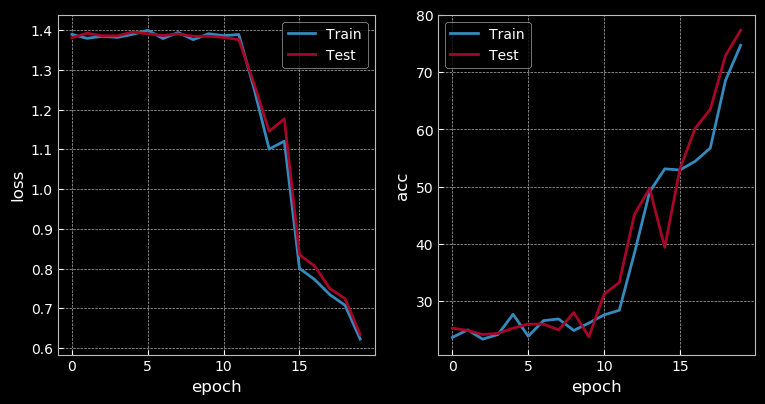

In [28]:
torch.manual_seed(1)

# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)


input_size  = train_data_gen.n_symbols
hidden_size = 12
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs = 20

model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    data = test_data_gen[0][0]
    X = torch.from_numpy(data).float().to(device)
    H_t, C_t = model.get_states_across_time(X)

In [29]:
print("Color range is as follows:")
print_colourbar()

Color range is as follows:


In [30]:
plot_state(X.cpu(), C_t, b=9, decoder=test_data_gen.decode_x) 

In [31]:
plot_state(X.cpu(), H_t, b=9, decoder=test_data_gen.decode_x)